In [82]:
import numpy as np
import numpy.polynomial as P
import scipy as sp
from matplotlib import pyplot as plt
from tqdm import tqdm
#from sklearn.preprocessing import PolynomialFeatures
from multiprocessing import Pool
import multiprocessing
import ZVnbrosse
from zv_cv import Eval_ZVCV
from potentials import GaussPotential,GaussMixture,GausMixtureIdent,GausMixtureSame,potentialRegression
from samplers import MCMC_sampler,Generate_train,ULA_light
from baselines import set_function,construct_ESVM_kernel,GenerateSigma,standartize
from sklearn.model_selection import train_test_split
from martingale import approx_q,test_traj
from optimize import Run_eval_test,optimize_parallel_new 
from utils import *
import pandas as pd
import copy

In [102]:
dataset = "pima" # Switch between "swiss" and "pima" 
intercept = True # Do we include the intercept
typ = "logistic" #logistic or probit are expected
test_size = 20

# Switch between "posterior_prob_point", "posterior_prob_mean", "posterior_prob_variance", "posterior_mean"
if typ == "logistic":
    f_type = "posterior_prob_mean"
elif typ == "probit":
    f_type = "posterior_prob_mean_point"

### Loading data

In [103]:
if (dataset == "swiss"):
    data = pd.read_csv("./data/swiss.csv",header=None)
    outliers_inds = np.array([])
    Y = data.iloc[:,-1]
    X = data.iloc[:,:-1]
elif (dataset == "eeg"):   
    data = pd.read_csv("../iZAV_code/data/eeg.csv",header=None)
    outliers_inds = np.array([13179,11509,898,10386])
    Y = data.iloc[:,-1]
    X = data.iloc[:,:-1]
elif (dataset == "pima"):
    data = pd.read_csv("./data/pima.csv",header=None)
    outliers_inds = np.array([])
    Y = data.iloc[:,-1]
    X = data.iloc[:,:-1]
elif (dataset == "susy"): 
    data = pd.read_csv("data/susy.csv",header=None)
    outliers_inds = np.array([267630])
    Y = data.iloc[:,0]
    X = data.iloc[:,1:]

### Preprocessing data

In [104]:
# Removing the outliers
if (outliers_inds.size!=0):
    X_processed = np.delete(np.asarray(X),outliers_inds,0)
    mask = np.ones(len(Y),dtype = bool)
    mask[outliers_inds] = False
    Y_processed = Y[mask]
    Y_processed = np.asarray(Y_processed)
    X_processed = np.asarray(X_processed)
else:
    Y_processed = np.asarray(Y)
    X_processed = np.asarray(X)

In [105]:
if (f_type == "posterior_mean" or f_type == "sum"):
    X_train,X_train = standartize(X_processed,X_processed,intercept=intercept)
    Y_train = Y_processed
else:
    X_train,X_test,Y_train,Y_test = train_test_split(X_processed,Y_processed,test_size=test_size,random_state=1812,stratify=Y_processed)
    X_train,X_test = standartize(X_train,X_test,intercept=intercept)

In [106]:
if (f_type == "posterior_mean" or f_type == "sum"):
    inds_arr = np.array([1]) # Taking the second index (not intercept)
    params = None
else:
    params = {"X":X_test,"Y":Y_test}
    inds_arr = np.array([0])

### Creating potential

In [107]:
# Creating potential
Cur_pot = potentialRegression(Y_train, X_train, typ, print_info = True)
d = Cur_pot.d
print(d)

9


### Data generation

In [108]:
N_burn = 1*10**4 # Burn in period
N_train = 1*10**5 # Number of samples on which we optimize
step = 1.0 # Step size
n_traj = 24

### Evaluate methods (EVM and CV methods)

In [109]:
sampler = {"sampler":"MALA","burn_type":"full","main_type":"full"} # Sampling method

if sampler["sampler"] == "ULA":
    res = Generate_train(n_traj, sampler, Cur_pot, step, N_burn, N_train, d)
    res = np.asarray(res)
    traj,traj_grad = res[:,0,:,:],res[:,1,:,:]
else:
    res = Generate_train(n_traj, sampler, Cur_pot, step, N_burn, N_train, d)
    traj = []
    traj_grad = []
    for i in range(len(res)):
        traj.append(res[i][0])
        traj_grad.append(res[i][1])
        print("accepted = ",res[i][2])
    traj = np.asarray(traj)
    traj_grad = np.asarray(traj_grad)

ncores =  12
accepted =  93992
accepted =  93944
accepted =  93942
accepted =  94106
accepted =  94001
accepted =  94086
accepted =  93869
accepted =  93966
accepted =  93776
accepted =  93892
accepted =  93946
accepted =  93778
accepted =  93883
accepted =  94040
accepted =  93843
accepted =  93933
accepted =  93983
accepted =  93907
accepted =  93928
accepted =  93937
accepted =  93770
accepted =  94002
accepted =  93879
accepted =  93888


In [110]:
print(traj.shape)
print(traj_grad.shape)
traj_grad = (-1)*traj_grad

(24, 100000, 9)
(24, 100000, 9)


In [111]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(Eval_ZVCV, [(traj[i,:,:],traj_grad[i,:,:],f_type,params) for i in range (n_traj)])
trav.close()

(100000, 1)
(100000, 1)
(100000, 1)
(100000, 1)
(100000, 1)
(100000, 1)
(100000, 1)
(100000, 1)
(100000, 1)
(100000, 1)
(100000, 1)
(100000, 1)
(100000, 1)
(100000, 1)
(100000, 1)
(100000, 1)
(100000, 1)
(100000, 1)
(100000, 1)
(100000, 1)
(100000, 1)
(100000, 1)
(100000, 1)
(100000, 1)


In [112]:
res_arr = np.asarray(res)
print(res_arr.shape)

(24, 5)


### Comparison plots

In [113]:
title = ""
labels = ['Vanilla\n ULA', 'ULA \nwith ZV-1', 'ULA \nwith CV-1']

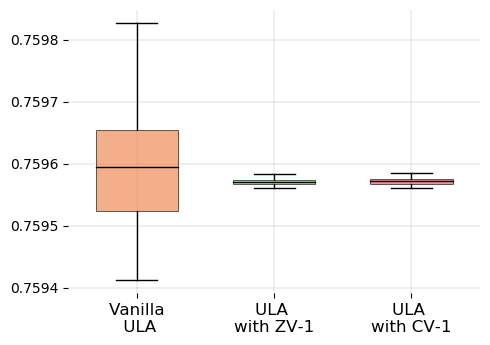

In [114]:
data = [res_arr[:,0],res_arr[:,1],res_arr[:,3]] 
boxplot_ind(data, title, labels)

In [115]:
title = ""
labels = ['ULA \nwith ZV-1', 'ULA \nwith CV-1']

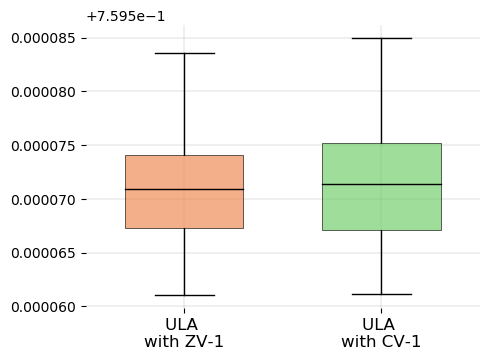

In [116]:
data = [res_arr[:,1],res_arr[:,3]] 
boxplot_ind(data, title, labels)

In [117]:
title = ""
labels = ['Vanilla\n ULA', 'ULA \nwith ZV-2', 'ULA \nwith CV-2']

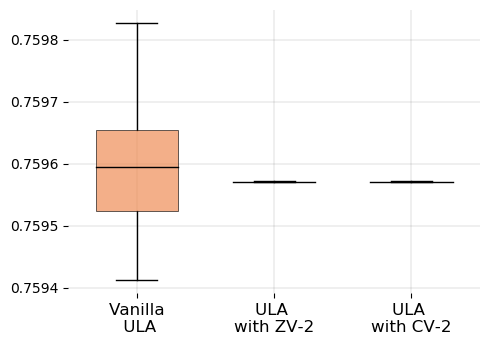

In [118]:
data = [res_arr[:,0],res_arr[:,2],res_arr[:,4]] 
boxplot_ind(data, title, labels)

In [119]:
title = ""
labels = ['ULA \nwith ZV-2', 'ULA \nwith CV-2']

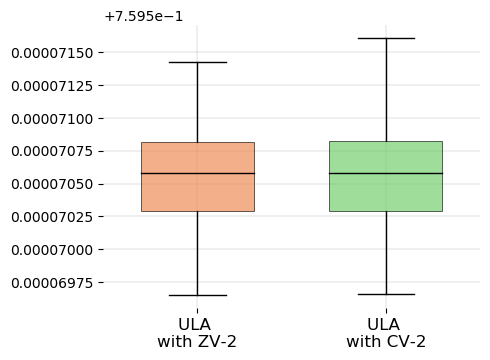

In [120]:
data = [res_arr[:,2],res_arr[:,4]] 
boxplot_ind(data, title, labels)